In [1]:
import numpy as np
import pandas as pd
import random
import datetime

import warnings

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
import category_encoders as ce

In [2]:
inputData_chunks = pd.read_csv('C:/Users/enggj/Downloads/avazu-ctr-prediction/train/train.csv', chunksize=1000000)
kaggleData = pd.read_csv('C:/Users/enggj/Downloads/avazu-ctr-prediction/test/test.csv')

In [3]:
sampleSize = 0
for chunk in inputData_chunks:
    sampleSize += chunk.shape[0]

print('Total input data records are {}'.format(sampleSize))

Total input data records are 40428967


In [4]:
trainSize = 100000
valSize = 10000
testSize = 10000

skip_rows = sorted(random.sample(range(1,sampleSize), sampleSize - (trainSize+valSize+testSize)))

inputData = pd.DataFrame()
inputData = pd.read_csv('C:/Users/enggj/Downloads/avazu-ctr-prediction/train/train.csv', skiprows=skip_rows, parse_dates=['hour'], date_parser = lambda val : pd.datetime.strptime(val, '%y%m%d%H'))

inputData = inputData.drop(['id'], axis=1)

C:\Users\enggj\AppData\Local\Temp\ipykernel_27108\529836552.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  inputData = pd.read_csv('C:/Users/enggj/Downloads/avazu-ctr-prediction/train/train.csv', skiprows=skip_rows, parse_dates=['hour'], date_parser = lambda val : pd.datetime.strptime(val, '%y%m%d%H'))


In [5]:
inputData.to_pickle("C:/Users/enggj/Downloads/mss_portfolio/inputData.pkl") 

In [2]:
inputData = pd.read_pickle("C:/Users/enggj/Downloads/mss_portfolio/inputData.pkl")

### Data Split

In [3]:
continuous_variables = list(inputData.columns[inputData.dtypes=='int64'][1:].values)
disguised_cols = ['C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15','C16','C17','C18','C19','C20','C21']
[continuous_variables.remove(col) for col in disguised_cols]
categorical_variables = list(inputData.columns[inputData.dtypes=='O'].values)
categorical_variables.extend(disguised_cols)

y = inputData['click']
X_train, X_test, y_train, y_test = train_test_split(inputData.loc[:,categorical_variables], y, test_size=0.15, random_state=42, stratify=y)

### 1. Exploratory Data Analysis

##### 1.1 Class Imbalance

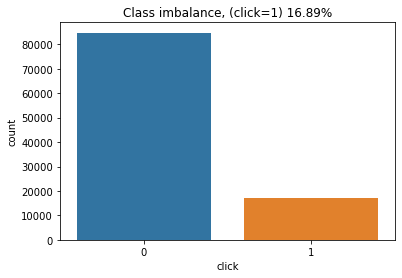

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics 

sns.countplot(x='click',data=pd.concat([X_train,y_train],axis=1))
plt.title("Class imbalance, (click=1) "+ str(round(100*sum(y_train==1)/X_train.shape[0],2))+"%")
plt.show()

##### 1.2 Empirical probabilities of CTR; for categorical covariates

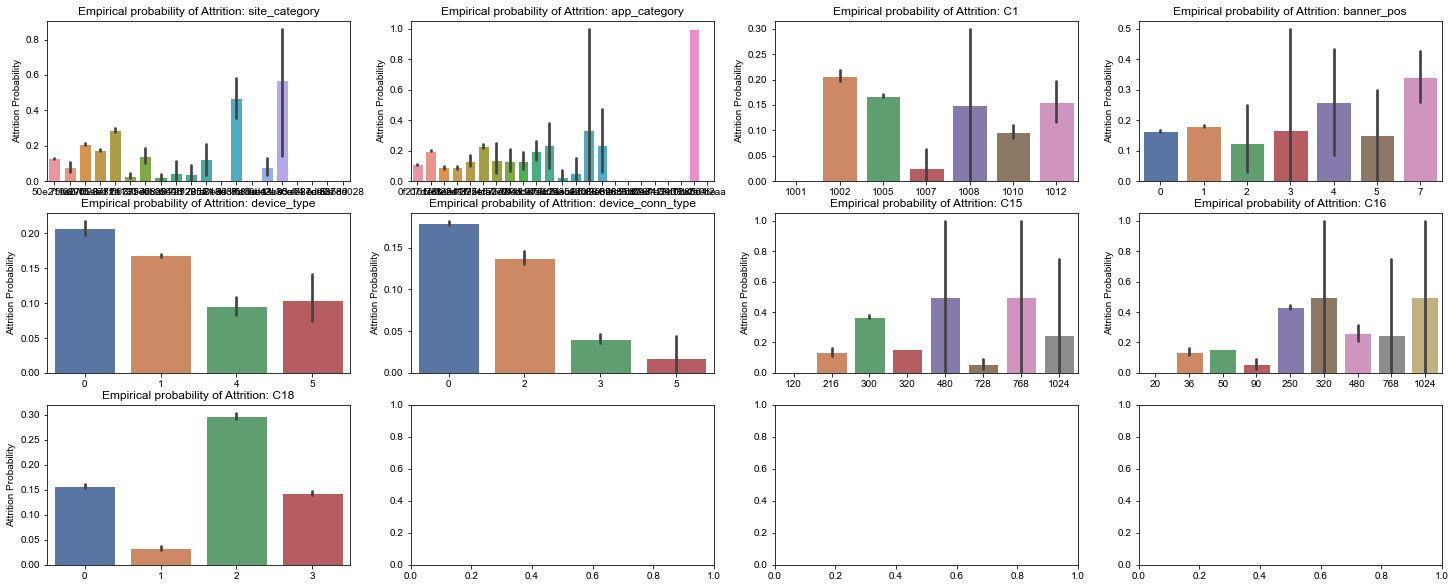

In [5]:
def covariate_empirical_prob(all_data,xcol,ax):
    sns.set(style="darkgrid")
    sns.barplot(data=all_data, x=xcol, y=all_data.click,ax=ax)
    ax.set_title("Empirical probability of Attrition: "+xcol)
    ax.set_ylabel("Attrition Probability")
    ax.set_xlabel("")
    

fig,ax = plt.subplots(3,4)
fig.set_figwidth(25)
fig.set_figheight(10)

features_subset_visualize = pd.concat([X_train.loc[:,X_train.nunique()<25], y_train],axis=1)
for i,xcol in enumerate(features_subset_visualize.columns[:-1]):
    covariate_empirical_prob(features_subset_visualize,xcol,ax[int(i/4),int(i%4)])
plt.show()



##### 1.3 Missing Data check

In [6]:
inputData.isnull().any().any()

False

### 2. Encoding categorical data

In [7]:
def get_results(algoName,clf,param_grid):
    search_cv = RandomizedSearchCV(clf, param_grid, n_iter=5, random_state=0, scoring='roc_auc', cv=5, verbose=2, refit=True)
    search_cv.fit(X_train, y_train)
    output = [algoName, search_cv.best_score_, search_cv.score(X_test, y_test)]
    return output

def get_preprocessor(categorical_transformer, categorical_variables):
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", categorical_transformer, categorical_variables),
        ]
    )
    return preprocessor

def fit_models(categorical_transformer,fit_logistic,fit_gradient_boosting):
    res = fit_logistic(categorical_transformer, categorical_variables,X_train, y_train,X_test, y_test)
    res1 = fit_gradient_boosting(categorical_transformer, categorical_variables,X_train, y_train,X_test, y_test)
    output = pd.DataFrame([res,res1], columns=["Model","Avg CV score", "Test score"])
    return output
    


In [8]:
def fit_logistic(categorical_transformer, categorical_variables,X_train, y_train,X_test, y_test):
    print("Fitting Logistic Regression")
    warnings.filterwarnings('ignore')
    preprocessor = get_preprocessor(categorical_transformer, categorical_variables)

    clf = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=100))]
    )
    param_grid = {
        "classifier__C": [0.01, 0.1, 1, 10, 100],
    }
    output = get_results("Logistic Regression",clf,param_grid)
    return output

In [9]:
def fit_gradient_boosting(categorical_transformer, categorical_variables,X_train, y_train,X_test, y_test):
    print("Fitting Gradient Boosting Trees")
    warnings.filterwarnings('ignore')
    preprocessor = get_preprocessor(categorical_transformer, categorical_variables)

    clf = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", GradientBoostingClassifier())]
    )
    param_grid = {
        "classifier__n_estimators": [50, 75, 100],
        "classifier__min_samples_split": [2, 5, 9],
        "classifier__max_depth": [1, 5, 9], 
        "classifier__max_features": ['sqrt', 'log2', None],                       
    }
    output = get_results("Gradient Boosting",clf,param_grid)
    return output


##### 2.1 One Hot Encoding: 

In [10]:
cardinality = X_train.apply(lambda x: len(x.unique()), axis=0).to_frame(name="cardinality")
print(cardinality)
print("One hot encoding leads to {} columns".format(cardinality.sum()[0]))

                  cardinality
site_id                  1487
site_domain              1351
site_category              20
app_id                   1339
app_domain                 97
app_category               23
device_id               17368
device_ip               79135
device_model             3198
C1                          7
banner_pos                  7
device_type                 4
device_conn_type            4
C14                      1701
C15                         8
C16                         9
C17                       395
C18                         4
C19                        64
C20                       155
C21                        60
One hot encoding leads to 106436 columns


In [11]:
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
    ]
)

output_oneHot = fit_models(categorical_transformer,fit_logistic,fit_gradient_boosting)
output_oneHot['Encoding'] = "One Hot Encoding"


Fitting Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .................................classifier__C=0.01; total time=   2.4s
[CV] END .................................classifier__C=0.01; total time=   2.4s
[CV] END .................................classifier__C=0.01; total time=   2.5s
[CV] END .................................classifier__C=0.01; total time=   2.6s
[CV] END .................................classifier__C=0.01; total time=   2.7s
[CV] END ..................................classifier__C=0.1; total time=   3.1s
[CV] END ..................................classifier__C=0.1; total time=   3.0s
[CV] END ..................................classifier__C=0.1; total time=   3.2s
[CV] END ..................................classifier__C=0.1; total time=   3.3s
[CV] END ..................................classifier__C=0.1; total time=   3.6s
[CV] END ....................................classifier__C=1; total time=   3.0s
[CV] END ............

##### 2.2 Ordinal Encoding:

In [14]:
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ]
)

output_ordinal = fit_models(categorical_transformer,fit_logistic,fit_gradient_boosting)
output_ordinal['Encoding'] = "Ordinal Encoding"

Fitting Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .................................classifier__C=0.01; total time=   1.4s
[CV] END .................................classifier__C=0.01; total time=   1.3s
[CV] END .................................classifier__C=0.01; total time=   1.3s
[CV] END .................................classifier__C=0.01; total time=   1.3s
[CV] END .................................classifier__C=0.01; total time=   1.3s
[CV] END ..................................classifier__C=0.1; total time=   1.5s
[CV] END ..................................classifier__C=0.1; total time=   1.4s
[CV] END ..................................classifier__C=0.1; total time=   1.4s
[CV] END ..................................classifier__C=0.1; total time=   1.3s
[CV] END ..................................classifier__C=0.1; total time=   1.4s
[CV] END ....................................classifier__C=1; total time=   1.4s
[CV] END ............

##### 2.3 Binary Encoding:

In [15]:
encoder = ce.BinaryEncoder(cols=categorical_variables, handle_unknown="value")
df = encoder.fit_transform(X_train)
print("Binary Encoding leads to {} columns".format(len(df.columns)))

Binary Encoding leads to 158 columns


In [16]:
categorical_transformer = Pipeline(
    steps=[
        ("encoder", ce.BinaryEncoder(cols=categorical_variables, handle_unknown="value"))
    ]
)

output_binary = fit_models(categorical_transformer,fit_logistic,fit_gradient_boosting)
output_binary['Encoding'] = "Binary Encoding"

Fitting Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .................................classifier__C=0.01; total time=   7.9s
[CV] END .................................classifier__C=0.01; total time=   7.5s
[CV] END .................................classifier__C=0.01; total time=   7.2s
[CV] END .................................classifier__C=0.01; total time=   8.0s
[CV] END .................................classifier__C=0.01; total time=   7.7s
[CV] END ..................................classifier__C=0.1; total time=   9.2s
[CV] END ..................................classifier__C=0.1; total time=   8.9s
[CV] END ..................................classifier__C=0.1; total time=   8.8s
[CV] END ..................................classifier__C=0.1; total time=   9.4s
[CV] END ..................................classifier__C=0.1; total time=   7.6s
[CV] END ....................................classifier__C=1; total time=   7.8s
[CV] END ............

##### 2.4 : Frequency Encoding

In [17]:
categorical_transformer = Pipeline(
    steps=[
        ("encoder", ce.CountEncoder(cols=categorical_variables, handle_unknown="value", normalize=True, min_group_size=100))
    ]
)

output_frequency = fit_models(categorical_transformer,fit_logistic,fit_gradient_boosting)
output_frequency['Encoding'] = "Frequency Encoding"

Fitting Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .................................classifier__C=0.01; total time=   3.8s
[CV] END .................................classifier__C=0.01; total time=   3.8s
[CV] END .................................classifier__C=0.01; total time=   3.8s
[CV] END .................................classifier__C=0.01; total time=   3.8s
[CV] END .................................classifier__C=0.01; total time=   3.9s
[CV] END ..................................classifier__C=0.1; total time=   4.1s
[CV] END ..................................classifier__C=0.1; total time=   4.6s
[CV] END ..................................classifier__C=0.1; total time=   4.7s
[CV] END ..................................classifier__C=0.1; total time=   5.2s
[CV] END ..................................classifier__C=0.1; total time=   4.1s
[CV] END ....................................classifier__C=1; total time=   4.3s
[CV] END ............

##### 2.5 : Target Encoding

In [19]:
categorical_transformer = Pipeline(
    steps=[
        ("encoder", ce.TargetEncoder(cols=categorical_variables, handle_unknown="value"))
    ]
)

output_target = fit_models(categorical_transformer,fit_logistic,fit_gradient_boosting)
output_target['Encoding'] = "Target Encoding"

Fitting Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .................................classifier__C=0.01; total time=   3.1s
[CV] END .................................classifier__C=0.01; total time=   3.1s
[CV] END .................................classifier__C=0.01; total time=   3.1s
[CV] END .................................classifier__C=0.01; total time=   3.1s
[CV] END .................................classifier__C=0.01; total time=   3.1s
[CV] END ..................................classifier__C=0.1; total time=   3.2s
[CV] END ..................................classifier__C=0.1; total time=   3.2s
[CV] END ..................................classifier__C=0.1; total time=   3.2s
[CV] END ..................................classifier__C=0.1; total time=   3.2s
[CV] END ..................................classifier__C=0.1; total time=   3.2s
[CV] END ....................................classifier__C=1; total time=   3.4s
[CV] END ............

##### 2.6 : Hashing

In [20]:
encoder = ce.HashingEncoder(cols=categorical_variables, n_components=32)
df = encoder.fit_transform(X_train)
print("Hashing Encoding leads to {} columns".format(len(df.columns)))

Hashing Encoding leads to 32 columns


In [21]:
categorical_transformer = Pipeline(
    steps=[
        ("encoder", ce.HashingEncoder(cols=categorical_variables, n_components=32))
    ]
)

output_hashing = fit_models(categorical_transformer,fit_logistic,fit_gradient_boosting)
output_hashing['Encoding'] = "Hashing Encoding"

Fitting Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .................................classifier__C=0.01; total time=  29.6s
[CV] END .................................classifier__C=0.01; total time=  29.8s
[CV] END .................................classifier__C=0.01; total time=  29.9s
[CV] END .................................classifier__C=0.01; total time=  29.7s
[CV] END .................................classifier__C=0.01; total time=  29.6s
[CV] END ..................................classifier__C=0.1; total time=  29.6s
[CV] END ..................................classifier__C=0.1; total time=  29.6s
[CV] END ..................................classifier__C=0.1; total time=  29.6s
[CV] END ..................................classifier__C=0.1; total time=  30.0s
[CV] END ..................................classifier__C=0.1; total time=  29.9s
[CV] END ....................................classifier__C=1; total time=  29.6s
[CV] END ............

##### 2.7 : Quantile(50%) Encoding

In [22]:
categorical_transformer = Pipeline(
    steps=[
        ("encoder", ce.QuantileEncoder(cols=categorical_variables, quantile=0.5, handle_missing='value'))
    ]
)

output_quantile = fit_models(categorical_transformer,fit_logistic,fit_gradient_boosting)
output_quantile['Encoding'] = "Quantile Encoding"

Fitting Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .................................classifier__C=0.01; total time=  16.4s
[CV] END .................................classifier__C=0.01; total time=  14.1s
[CV] END .................................classifier__C=0.01; total time=  13.1s
[CV] END .................................classifier__C=0.01; total time=  12.9s
[CV] END .................................classifier__C=0.01; total time=  13.0s
[CV] END ..................................classifier__C=0.1; total time=  13.4s
[CV] END ..................................classifier__C=0.1; total time=  14.7s
[CV] END ..................................classifier__C=0.1; total time=  14.5s
[CV] END ..................................classifier__C=0.1; total time=  12.9s
[CV] END ..................................classifier__C=0.1; total time=  14.9s
[CV] END ....................................classifier__C=1; total time=  16.4s
[CV] END ............

In [25]:
output = pd.concat([output_oneHot, output_ordinal, output_binary, output_frequency, output_target, output_hashing, output_quantile],axis=0)

In [27]:
output.to_pickle("C:/Users/enggj/Downloads/mss_portfolio/output.pkl") 

In [28]:
output1 = pd.read_pickle("C:/Users/enggj/Downloads/mss_portfolio/output.pkl")

In [29]:
output1

,Model,Avg CV score,Test score,Encoding
0,Logistic Regression,0.730193,0.727923,One Hot Encoding
1,Gradient Boosting,0.704358,0.697265,One Hot Encoding
0,Logistic Regression,0.576326,0.569783,Ordinal Encoding
1,Gradient Boosting,0.689237,0.690202,Ordinal Encoding
0,Logistic Regression,0.686627,0.687019,Binary Encoding
1,Gradient Boosting,0.719450,0.717643,Binary Encoding
0,Logistic Regression,0.628360,0.621864,Frequency Encoding
1,Gradient Boosting,0.702945,0.700258,Frequency Encoding
0,Logistic Regression,0.708825,0.703415,Target Encoding
1,Gradient Boosting,0.693570,0.691067,Target Encoding
